In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
from torch import optim

In [3]:
from utils_DRD import get_repr_DTI

In [4]:
from data_tool_box_DRD import str2bool, load_pkl
# from DTI_meta_MAML_DRD import meta_DTI_MAML
from models_MAML import DTI_model_MAML

In [5]:
parser=argparse.ArgumentParser()
parser.add_argument('--frozen',default="none",type=str)
parser.add_argument('--cwd',default="../",type=str)
parser.add_argument('--batch_size',default=6,type=int)
parser.add_argument('--meta_lr',default=1e-3,type=float)
parser.add_argument('--global_MAML_step', default=20, type=int,
                    help='Number of global training steps, i.e. numberf of mini-batches ')
parser.add_argument('--val_range',default=1,type=int)
opt= parser.parse_args('')

In [6]:
args = {}
args.update(vars(opt))

In [7]:
train = pd.read_csv('../data/train_set.csv')

test=pd.read_csv('../data/test_set.csv')

In [36]:
model = DTI_model_MAML(all_config=args).to('cuda').double()

loaded DISAE :)


In [9]:
criterion=nn.MSELoss(reduction='mean')
# loss_fn = torch.nn.CrossEntropyLoss()

In [10]:
tokenizer = model.prot_tokenizer

In [11]:
chem_dict = pd.Series(load_pkl( args['cwd']+'data/ChEMBLE26/chemical/ikey2smiles_ChEMBLE.pkl'))
protein_dict = pd.Series(load_pkl(args['cwd']+'data/ChEMBLE26/protein/unipfam2triplet.pkl'))


In [12]:
meta_optim = optim.Adam(model.parameters(), lr=args['meta_lr'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(meta_optim, T_max=10)

In [38]:
train_classic_performance = {'loss': [], 'overall': []}

In [32]:
loss.dtype

torch.float32

In [35]:
loss.float().dtype

torch.float32

In [39]:
for step in range(args['global_MAML_step']):
    model.train()
    print(step)
    batch = train.sample(args['batch_size'])
    chem_graph, protein_tokenized = get_repr_DTI(batch, tokenizer, chem_dict, protein_dict, 'DISAE')
    logit = model(protein_tokenized.to('cuda'),chem_graph.to('cuda'))
#     label = transform(batch['BEL-level'].values)
#     level = torch.tensor(batch['BEL-level'].values)
#     outp = result_transform.convert_continuous(logit.to('cuda'))
#     loss = loss_fn(logit.cpu(),level)
    loss= criterion(logit.cpu(),torch.tensor(batch['ic_value'].values))
    meta_optim.zero_grad()
    loss.backward()
    meta_optim.step()
    scheduler.step()
    train_classic_performance['loss'].append(loss.detach().cpu().item())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


# plot

In [40]:
import matplotlib.pyplot as plt

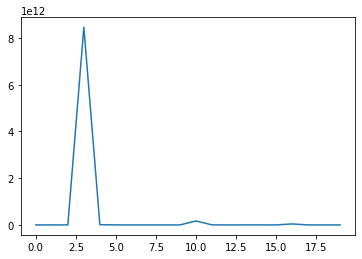

In [41]:
plt.plot(range(len(train_classic_performance['loss'])), train_classic_performance['loss'])

In [42]:
train_classic_performance['loss']

[66272606.727438584,
 620032817.9732764,
 36219697.83325574,
 8456840080313.564,
 10416669008.15908,
 269893547.6149056,
 388898480.6882363,
 16670637.999838706,
 11872.167619464608,
 16666955.174026778,
 168360622680.23596,
 1676317780.4860272,
 72025076.92613272,
 1005290400.4666276,
 579719961.1665894,
 80789545.3331951,
 41671180026.748505,
 915701.1120153868,
 171245966.66659722,
 22572.06382649324]

# dissect

In [13]:
batch = train.sample(args['batch_size'])

In [14]:
batch

,InChIKey,SMILES,uniprot+pfam,ic_value,ic_str,sentence_len,log(ic),BEL-level
14941,AEGMQTAGVURKHK-CKNUHMDMSA-N,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,P30559|PF00001,7.0,7.0,17,1.945910,3
12681,WVDFTSHLRHONNQ-UHFFFAOYSA-N,Cc1ccc(S(=O)(=O)N2CCC(C(=O)Nc3ccccc3C)CC2)c(C)c1,P34913|PF00561,20.0,20.0,18,2.995732,4
1366,BBTANPTXEJOKGM-OEAKJJBVSA-N,C/C(CC1CCC2C3CCC4=CC(=O)CCC4(C)C3CCC12C)=N\\O,P18405|PF02544,900.0,900.0,17,6.802395,5
2723,RODBHZMFOOEMOU-UHFFFAOYSA-N,CN(C)C(=O)c1ccc(-c2cc(-c3ccsc3)cnc2N)cc1,O96017|PF00069,6100.0,6100.0,6,8.716044,6
16108,TYYQIBDJBZYMOH-MPQUPPDSSA-N,CCOc1ccc(C[C@@H](NC(=O)c2cccc3ccccc23)C(=O)N[C...,P03952|PF00089,83.0,83.0,4,4.418841,4
21185,KDNSQBSCUAOXCF-UHFFFAOYSA-N,Fc1ccc(Nc2nc(N3CCN(c4ccccc4)CC3)nc3[nH]ncc23)cc1,P28335|PF00001,416.0,416.0,18,6.030685,5


In [15]:
chem_graph,protein_tokenized = get_repr_DTI(batch,tokenizer,chem_dict,protein_dict,'DISAE')

In [16]:
chem_graph.to('cuda')

Batch(batch=[221], edge_attr=[476, 2], edge_index=[2, 476], x=[221, 6])

In [17]:
logit = model(protein_tokenized.to('cuda'),chem_graph.to('cuda'))

In [18]:
logit.shape

torch.Size([6, 1])

In [25]:
loss= criterion(logit.cpu(),torch.tensor(batch['ic_value'].values))

In [26]:
loss


tensor(6366733.3332, dtype=torch.float64, grad_fn=<MseLossBackward>)